In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from IPython.display import display, Image
import ipywidgets as widgets
import threading

In [3]:
import pathlib
data_dir = "leaf_photos"
data_dir = pathlib.Path(data_dir)


now have a copy of the dataset available.

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

5178


Here are some bactrial spot:

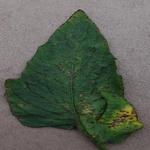

In [5]:
bacterial_spots = list(data_dir.glob('Tomato_Bacterial_Spot/*'))
PIL.Image.open(str(bacterial_spots[0]))

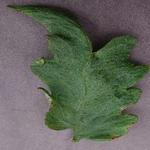

In [6]:
PIL.Image.open(str(bacterial_spots[1]))

And some healthy:

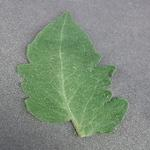

In [7]:
healthys = list(data_dir.glob('Tomato_Healthy/*'))
PIL.Image.open(str(healthys[0]))

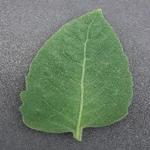

In [8]:
PIL.Image.open(str(healthys[1]))

## Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5178 files belonging to 13 classes.
Using 4143 files for training.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5178 files belonging to 13 classes.
Using 1035 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [12]:
class_names = train_ds.class_names
print(class_names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Tomato_Bacterial_Spot', 'Tomato_Early_Blight', 'Tomato_Healthy', 'Tomato_Leaf_mold', 'Tomato_Septorial_Leaf_Spot', 'Tomato_Yellow_Leaf_Curl_Virus']


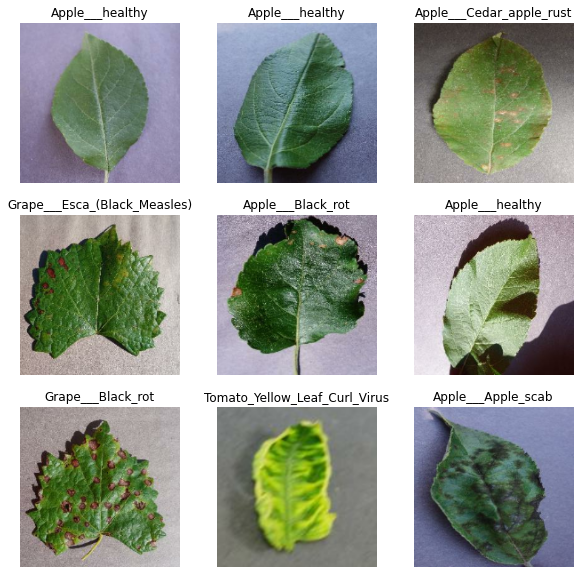

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [16]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image)) 

0.0 0.8702614


In [18]:
num_classes = 13

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
model.load_weights('my_checkpoint.ckpt')

## Predict on new data

Note: Data augmentation and Dropout layers are inactive at inference time.
Example output

This image most likely belongs to Tomato_Bacterial_Spot with a 87.38 percent confidence.


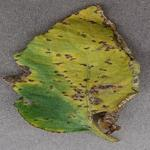

In [20]:
test_image_path = "bac_spot.jpg"

img = keras.preprocessing.image.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(test_image_path)

In [21]:
import ipywidgets as widgets

In [22]:

uploader = widgets.FileUpload(
    accept='',  
    multiple=False  
)
display(uploader)

FileUpload(value=(), description='Upload')

In [23]:
uploader.value
uploaded_file = uploader.value[0]
widgets.Image(value=uploaded_file.content.tobytes())
with open("uploaded.jpg", "wb") as fp:
     fp.write(uploaded_file.content.tobytes())

This image most likely belongs to Grape___Black_rot with a 99.89 percent confidence.


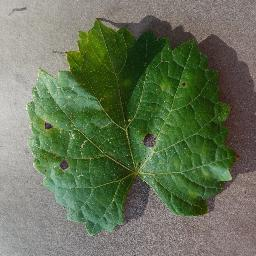

In [24]:
test_image_path2 = "uploaded.jpg"

img = keras.preprocessing.image.load_img(
    test_image_path2, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(test_image_path2)
